# 1. 패키지 정의

In [2]:
### 전처리에 사용
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
    
### 머신러닝에 사용
### 교차검증
from sklearn.model_selection import cross_validate

### 특성 중요도
from sklearn.inspection import permutation_importance

### 훈련 모델
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### 훈련모델 평가를 위한 metrics
# accuracy_score : 정확도
# precision_score : 정밀도
# recall_score : 재현율
# f1_score : F1 스코어
# plot_confusion_matrix : 혼동행렬 시각화
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# 2. 시각화 한글(Kor) 폰트(Font) 정의(최초 한번만 실행)

In [3]:
def initKorFont() :
    # 한글폰트 설정
    plt.rc('font', family='Malgun Gothic') 
    plt.rcParams['axes.unicode_minus'] = False

# 3. 전처리

### 3-1. 원본 데이터 읽어들여서 → 데이터프레임으로 정의

In [4]:
# 원본 데이터프레임 및 타켓 데이터프레임 정의
def getDataToDataframe(data_file_path) :
    
    ### 원본 데이터 읽어들이기
    tmp_data = pd.read_csv(data_file_path)
            
    ### 타겟 데이터 처리
    tmp_target = tmp_data["QC"]
    
    return tmp_data, tmp_target

### 3-2. 결측치 처리

In [ ]:
# p_data_df : 원본 데이터프레임
def addFeature(p_data_df) :
    
    ### 결측치가 있는 모든 행 삭제
    p_data_df = p_data_df.dropna(axis=0)
    
    ### 인덱스 순차적으로 재정의
    p_data_df = p_data_df.reset_index(drop=True, inplace=False)
    
    ### 전처리된 데이터프레임 리턴하기
    return p_data_df

# 4. 데이터 가공

### 4-1. 설명변수와 목표변수 간의 관계를 시각화 하기

In [ ]:
def viewX_Feature_Relationship(p_data_df, p_feature_name) :
    plt.figure(figsize=(30, 30))

    for col_idx in range(len(p_feature_name)):
        # 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(4, 2, col_idx+1)

        # 품질-정상에 해당하는 데이터 histogram 시각화
        plt.hist(p_data_df[p_data_df["QC"] == 0][p_feature_name[col_idx]], 
                 label = "품질-정상", alpha = 0.5)

        # 품질-불량에 해당하는 데이터 histogram 시각화
        plt.hist(p_data_df[p_data_df["QC"] == 1][p_feature_name[col_idx]], 
                 label = "품질-불량", alpha = 0.5)
        plt.legend(fontsize=15)

        # 그래프 타이틀: feature name
        plt.title("Feature: "+ p_feature_name[col_idx], fontsize = 20)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

    plt.savefig('./figure/viewX_Feature_Relationship.png')
    plt.show()

# 5. 데이터 정규화(Scaler)

### 5-1. MinMaxScaler, StandardScaler, RobustScaler 데이터 정규화

In [7]:
### 정규화 방법 3가지 처리 값을 모두 리턴하기
# return : MinMaxScaler, StandardScaler, RobustScaler

def getScalers(p_data_df) :

    df = p_data_df[["pH", "Temp", "Voltage"]].copy()

    ### 데이터 정규화 하기
    # 1. MinMaxScaler 정규화 데이터
    from sklearn.preprocessing import MinMaxScaler
    minmax_scaler = MinMaxScaler()
    # 정규화에 필요한 데이터만 추출하여 데이터프레임 생성하기
    # (정규화 시에는 일반 컬럼은 제외해야 함)
    df_minmax_scaler = df[["pH", "Temp", "Voltage"]].copy()
    df_minmax_scaler[ : ] = minmax_scaler.fit_transform(df_minmax_scaler[ : ])
    
    # 2. StandardScaler 정규화 데이터
    from sklearn.preprocessing import StandardScaler
    standard_scaler = StandardScaler()
    # 정규화에 필요한 데이터만 추출하여 데이터프레임 생성하기
    # (정규화 시에는 일반 컬럼은 제외해야 함)
    df_standard_scaler = df[["pH", "Temp", "Voltage"]].copy()
    df_standard_scaler[ : ] = standard_scaler.fit_transform(df_standard_scaler[ : ])
    
    # 3. RobustScaler 정규화 데이터
    from sklearn.preprocessing import RobustScaler
    robust_scaler = RobustScaler()
    # 정규화에 필요한 데이터만 추출하여 데이터프레임 생성하기
    # (정규화 시에는 일반 컬럼은 제외해야 함)
    df_robust_scaler = df[["pH", "Temp", "Voltage"]].copy()
    df_robust_scaler[ : ] = robust_scaler.fit_transform(df_robust_scaler[ : ])
    
    rs_scaler_list = [df_minmax_scaler, df_standard_scaler, df_robust_scaler]
    
    return rs_scaler_list[0], rs_scaler_list[1], rs_scaler_list[2]

# 6. 상관관계 분석

### 6-1. 정규화 데이터 상관관계도 그리기

In [8]:
### <상관관계계수> : https://wikidocs.net/157461
# p_df : minmax_scaler, standard_scaler, robust_scaler
# mode : pearson, kendall, spearman

def view_Corr(p_data_df, mode) :
    corr_df = p_data_df[["pH", "Temp", "Voltage", "QC"]].corr(method=mode).apply(lambda x: round(x ,3))

    ### 상관관계도-히트맵 시각화
    sns.heatmap(corr_df, annot=True, annot_kws=dict(color='green'), cmap='Greys')

    ### 상관관계-표
    return corr_df

# 7. 파일로 저장하기 : 전처리 및 가공 데이터 저장

### 7-1. 최종 처리 데이터(정규화 데이터) 파일로 저장하기

In [9]:
def saveScalerDataFrame(p_data_df, p_minmax_scaler, p_standard_scaler, p_robust_scaler) :
    # df_org, minmax_scaler, standard_scaler, robust_scaler
    df_list = [p_data_df, p_minmax_scaler, p_standard_scaler, p_robust_scaler]
    df_list_nm = ["df_org_preprod.csv", "minmax_scaler_preprod.csv", 
                  "standard_scaler_preprod.csv", "robust_scaler_preprod.csv"]

    for i in range(0, len(df_list), 1) :
        df_list[i].to_csv("./data/02_data_preprocess/{}".format(df_list_nm[i]), 
                          index=None, encoding="euc-kr")

### 7-2. 파일 읽어 들이기 : 전처리 등 최종 처리 결과 데이터 (모델 훈련에 사용)

In [10]:
def getScalerDataFrameAll() :
    # df_org, minmax_scaler, standard_scaler, robust_scaler
    df_list = []
    df_list_nm = ["df_org_preprod.csv", "minmax_scaler_preprod.csv", 
                  "standard_scaler_preprod.csv", "robust_scaler_preprod.csv"]

    for i in range(0, len(df_list_nm), 1) :
        df_list.append(pd.read_csv("./data/02_data_preprocess/{}".format(df_list_nm[i]), 
                                   encoding="euc-kr"))

    return df_list[0], df_list[1], df_list[2], df_list[3]

# <실행> -----------------------------------

# 1. 데이터 전처리, 패턴분석, 가공, 정규화, 상관관계분석

Index(['Temp', 'Voltage', 'pH'], dtype='object')


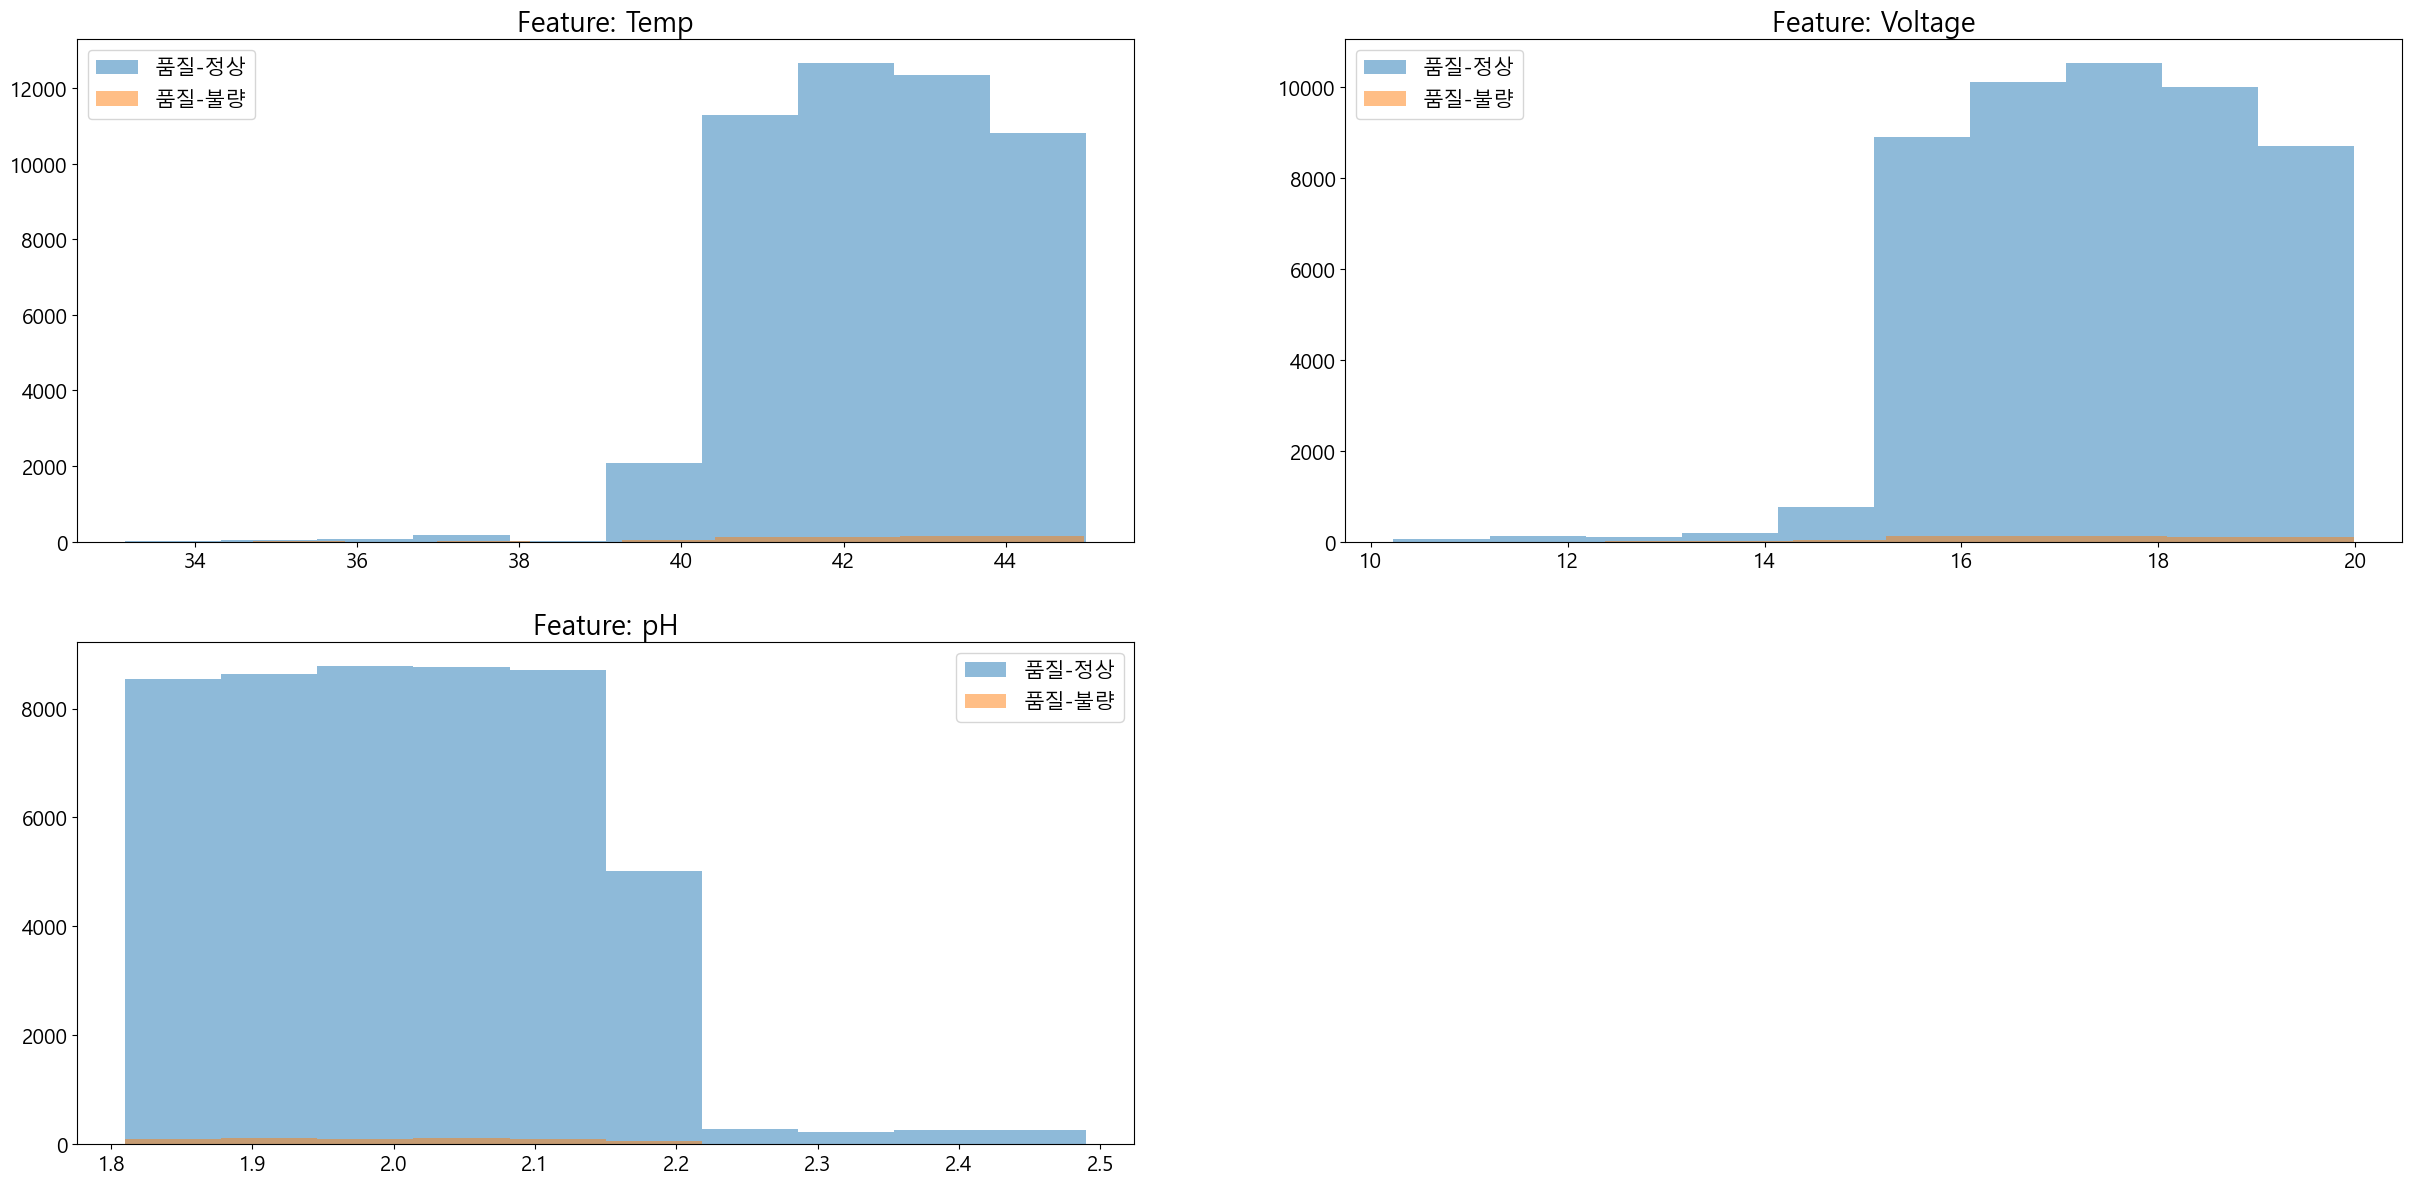

============ <전처리 파일 생성 종료> ============


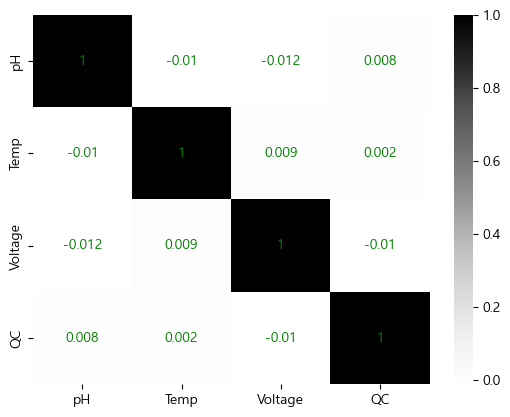

In [51]:
### 한글 폰트 정의
initKorFont()

### 원본데이터 및 타겟데이터를 데이터프레임으로 정의하기
df_data, df_target = getDataToDataframe("./data/01_org/final_df.csv")
# print(df_data.head(1), "\n [", len(df_data),  "건] \n", df_target.head(1),  "\n [", len(df_target), "건]")

### 전처리 : 특성 [컬럼(변수)] 추가 및 결측치 처리
df_data_prepro = df_data.copy()

### 최종 탐색(EDA)
# 설명변수별 목표변수 간의 관계 시각화
# 목표변수의 클래스를 두드러지게 구분짓는 설명변수 확인
x = df_data_prepro[df_data_prepro.columns.difference(["QC"])]
# print(x.head(1))

# 설명변수명 리스트
feature_name = x.columns
print(feature_name)

viewX_Feature_Relationship(df_data_prepro, feature_name)
### <정규화 하기> : https://jimmy-ai.tistory.com/139
# 정규화 데이터 적용
df_data_col_change = df_data_prepro.copy()
minmax_scaler, standard_scaler, robust_scaler = getScalers(df_data_col_change)

# ********************************************************************
# ************ 분석에 적용할 <정규화 데이터 지정>하기 ****************
# scaler = df_data_ifadd, minmax_scaler, standard_scaler, robust_scaler 이중에 1개 선택
scaler = df_data_col_change
# ********************************************************************

### <상관관계 확인하기> https://wikidocs.net/157461
# scaler : minmax_scaler, standard_scaler, robust_scaler
# mode : pearson, kendall, spearman
# 정규화 방법에 상관없이 모두 동일한 분포를 나타내고 있음
view_Corr(scaler, "spearman")

### [파일로 저장하기] 
# minmax_scaler, standard_scaler, robust_scaler 데이터 및 원본 df_data_ifadd 데이터를 파일로 모두 저장
saveScalerDataFrame(df_data_col_change, minmax_scaler, standard_scaler, robust_scaler)

print("============ <전처리 파일 생성 종료> ============")

# 2. 하이퍼파라메터 튜닝 > 모델 훈련 > 선정 > 저장

## 2-1. Classifier 기본 모델링 함수 정의 (하이퍼파라미터 조정 없이 모델 학습)

### 2-1-1. def : <머신러닝(ML) : 훈련모델에 적용할 train 및 test 데이터 생성하기> 
- train_input, test_input, train_target, test_target

In [12]:
### 훈련모델에 적용할 train_input, test_input, train_target, test_target 데이터 생성하기

def getTrain_Test_Data(scaler, test_size) :
    ### <입력 데이터(data)와 출력 데이터(target) 분류하기>
    # 입력 데이터 = data
    data = scaler[["pH", "Temp", "Voltage"]].to_numpy()
    # print("입력데이터(data)(행, 열) : ", data.shape)

    # 출력 데이터 = target
    target = scaler["QC"].to_numpy()
    # print("출력데이터(target)(행, 열) : ", target.shape)

    ### 훈련(train)데이터와 테스트(test)데이터로 분류하기
    # 분류 비율 = 훈련 : 테스트 = test_size 값으로 결정
    # stratify = target >> 원래 target 데이터의 비율대로 0과 1의 데이터를 각각 분리하기
    #                      (0과 1의 값이 비율대로 data 및 target 별로 각각 분배 된다)
    from sklearn.model_selection import train_test_split
    train_input, test_input, train_target, test_target = train_test_split(data, target, stratify=target,
                                                                          test_size=test_size, random_state=42)
    # print("훈련(train)-입력데이터(행, 열) : ", train_input.shape, " / 훈련(train)-출력데이터(행, 열) : ", train_target.shape)
    # print("테스트(test)-입력데이터(행, 열) : ", test_input.shape, " / 테스트(test)-출력데이터(행, 열) : ", test_target.shape)
    
    return train_input, test_input, train_target, test_target

### 2-1-2. 기본 모델 함수 정의 (하이퍼파라미터 조정 없이 모델 학습)

In [71]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(5)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(5)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    
    y_pred = uncustomized.predict(x_test)
    
    print(f"train_acc: {train_score_before:.4f}") # 훈련 정확도
    print(f"test_acc: {test_score_before:.4f}") # 예측 정확도
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}") # 예측 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.4f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.4f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}") # F1 스코어
    
    return train_score_before, test_score_before

## 2-2. 하이퍼파라미터별 모델 성능 시각화 함수 (공통 사용)

In [14]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    
    # 시각화한 그래프는 로컬에 저장
    plt.savefig('./figure/' + algorithm_name + '_' + filename + '.png') 

### 2-2-1. 하이퍼파라메터 모델 최적화 함수 - 학습할 트리 모델(루트 노드) 개수 선정

In [15]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]; minus = []
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        
        model.fit(x_train, y_train)
        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        minus.append(model.score(x_train, y_train) - model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score, 
                               'Minus': minus})
    
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    
    print(round(df_score_n, 5))

### 2-2-2. 하이퍼파라메터 모델 최적화 함수 - 트리 최대 깊이 선정
(루트노드 다음 중간노드부터 ~ 끝노드까지의 깊이 갯수)

In [16]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []; minus = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == RandomForestClassifier:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        minus.append(model.score(x_train, y_train) - model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score,
                               'Minus': minus})
    
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    
    print(round(df_score_n, 5))

### 2-2-3. 하이퍼파라메터 모델 최적화 함수 - 분리 노드(중간 노드들)의 최소 자료 수 선정

In [17]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []; minus = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == RandomForestClassifier:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
            
        model.fit(x_train, y_train)
        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        minus.append(model.score(x_train, y_train) - model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score, 
                               'Minus': minus})
    
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, 
                         "The minimum number of samples required to split an internal node", "min_samples_split")
    
    print(round(df_score_n, 5))

### 2-2-4. 하이퍼파라메터 모델 최적화 함수 - 잎사귀 노드(끝 노드)의 최소 자료 수 선정

In [18]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []; minus = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == RandomForestClassifier:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                              max_depth = n_depth,
                              min_samples_split = n_split,
                              random_state=1234)
            
        model.fit(x_train, y_train)
        
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
        minus.append(model.score(x_train, y_train) - model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score,
                               'Minus': minus})
    
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, 
                         "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    
    print(round(df_score_n, 5))

## 2-3. 최종 모델 학습 : 하이퍼파라메터를 적용한 최종 훈련모델 생성

In [53]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm_name == 'RandomForestClassifier':
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf, 
                          min_samples_split = n_split,  
                          max_depth = n_depth)
        
    elif algorithm_name == 'HistGradientBoostingClassifier':
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
#                           min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
        
        
        
    print("Model => ", model)    
    
    ### 모델 학습 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    model.fit(x_train, y_train)
    
    ### 모델 저장 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    import pickle
    model_path = './model2/'
    model_filename = 'classification_' + algorithm_name + '.pkl'
    
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    ### 최종 모델의 성능 평가 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    
    print(f"train_acc: {train_acc:.3f}") # 훈련 정확도
    print(f"test_acc: {test_acc:.3f}") # 예측 정확도
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 예측 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    
    ### 혼동행렬 시각화 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                          x_test, y_test,
                          include_values = True,
                          display_labels = ['미발생', '발생'], # 목표변수 이름
                          cmap = 'Pastel1') # 컬러맵
    
    plt.savefig('./figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    ### 변수 중요도 산출 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#     dt_importance = pd.DataFrame(columns=["Feature", "Importance"])
    dt_importance = pd.DataFrame()
    
    dt_importance['Feature'] = feature_name # 설명변수 이름
    
    if algorithm_name in ['RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier'] :
        dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출
    else :        
        result = permutation_importance(model, x_train, y_train, n_repeats=10,
                                        random_state=42, n_jobs=-1)        
        dt_importance['Importance'] = result.importances_mean # 설명변수 중요도 산출
    

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(5))
    
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    
    ### 변수 중요도 시각화 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    
    plt.savefig('./figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장
    

    df_models = pd.DataFrame({"Model_Name(모델명)" : [algorithm_name], 
                              "train_acc(훈련 정확도)" : [round(train_acc, 4)], 
                              "test_acc(예측 정확도)" : [round(accuracy_score(y_test, y_pred), 4)],  
                              "test-train(예측-훈련)" : [round(accuracy_score(y_test, y_pred) - train_acc, 4)], 
                              "Precision(정밀도)" : [round(precision_score(y_test, y_pred), 4)], 
                              "Recall(재현율)" : [round(recall_score(y_test, y_pred), 4)], 
                              "F1-score(F1스코어)" : [round(f1_score(y_test, y_pred), 4)]})
    
    return df_models

# 3. 모델 튜닝 및 훈련 모델 실행하기

## 3-1. Random Forest Classifier 기반 분류 모델 성능 

In [72]:
### 전처리가 완료된 데이터를 데이터프레임 형태로 불러오기
# return 값 : df_org, minmax_scaler, standard_scaler, robust_scaler
df_org, minmax_scaler, standard_scaler, robust_scaler = getScalerDataFrameAll()

### 훈련모델에 적용할 train_input, test_input, train_target, test_target 데이터 생성하기
# 파라메터값 : df_org, minmax_scaler, standard_scaler, robust_scaler 이중 한개 사용
x_train, x_test, y_train, y_test = getTrain_Test_Data(df_org, 0.4)

### 모델 지정하기
# 랜덤포레스트 분류 알고리즘
algorithm = RandomForestClassifier
algorithm_name = 'RandomForestClassifier'

train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_train,
                                                          y_train,
                                                          x_test,
                                                          y_test)

학습 데이터셋 정확도: 0.99993
테스트 데이터셋 정확도: 0.98762
train_acc: 0.9999
test_acc: 0.9876
Accuracy: 0.9876
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3-1-1. 모델 최적화 : (1) 학습할 트리 개수 선정

    n_estimators  TrainScore  TestScore    Minus
0              5     0.99621    0.98707  0.00913
1             10     0.99657    0.98757  0.00900
2             15     0.99834    0.98752  0.01081
3             20     0.99814    0.98752  0.01061
4             25     0.99920    0.98747  0.01173
5             30     0.99904    0.98752  0.01151
6             35     0.99927    0.98752  0.01174
7             40     0.99937    0.98762  0.01174
8             45     0.99967    0.98762  0.01204
9             50     0.99957    0.98762  0.01194
10            55     0.99973    0.98762  0.01211
11            60     0.99977    0.98762  0.01214
12            65     0.99987    0.98762  0.01224
13            70     0.99987    0.98762  0.01224
14            75     0.99990    0.98762  0.01228
15            80     0.99993    0.98762  0.01231
16            85     0.99990    0.98762  0.01228
17            90     0.99987    0.98762  0.01224
18            95     0.99993    0.98762  0.01231
19           100    

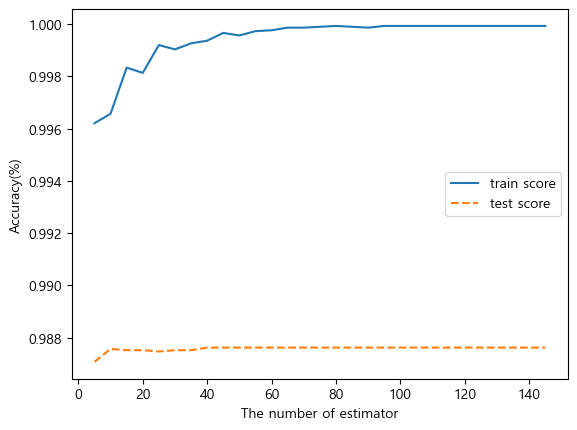

In [48]:
### 훈련에 사용할 최적의 트리 갯수를 확인하기 위하여,
### 최소~최대까지의 범위를 지정하여 테스트하기
### 범위 내에서 훈련 및 테스트 score를 확인하여 최적의 트리갯수 결정

n_estimator_min = 1
n_estimator_max = 30

optimi_estimator(algorithm, algorithm_name, 
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

In [56]:
### (해석)
# 학습 데이터에서 정확도가 100%에 가깝게 나타난 것으로 보아 과대적합 발생한 것으로 보임
# 트리개수가 적을수록 과대적합 방지가 용이함
# 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전의 트리 개수를 최적의 파라미터로 선정

### 학습할 트리개수 최종 선정
# 트리 개수가 80개 일 때 테스트 데이터 기반 모델 정확도가 가장 높음
# 트리 개수가 더 많아져도 성능에 차이가 없음
n_estimator = 40

### 3-1-2. 모델 최적화 : (2) 최대 깊이 선정

    depth  TrainScore  TestScore    Minus
0       1     0.98759    0.98762 -0.00003
1       2     0.98759    0.98762 -0.00003
2       3     0.98759    0.98762 -0.00003
3       4     0.98759    0.98762 -0.00003
4       5     0.98766    0.98762  0.00003
5       6     0.98769    0.98762  0.00007
6       7     0.98776    0.98762  0.00013
7       8     0.98786    0.98762  0.00023
8       9     0.98792    0.98762  0.00030
9      10     0.98802    0.98762  0.00040
10     11     0.98816    0.98762  0.00053
11     12     0.98855    0.98762  0.00093
12     13     0.98859    0.98762  0.00096
13     14     0.98882    0.98762  0.00120
14     15     0.98929    0.98762  0.00166
15     16     0.98995    0.98762  0.00233
16     17     0.99038    0.98762  0.00276
17     18     0.99125    0.98757  0.00368
18     19     0.99261    0.98762  0.00499
19     20     0.99428    0.98757  0.00670


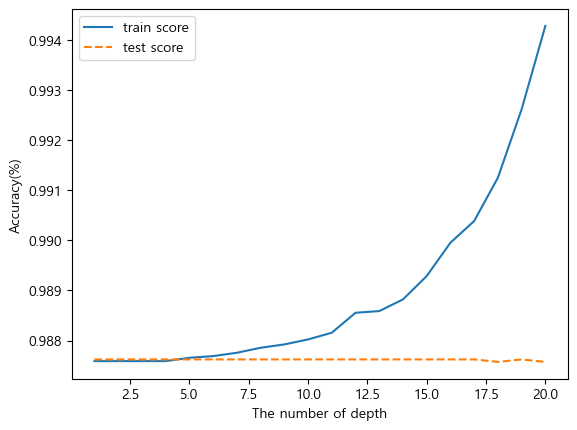

In [57]:
### 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 depth 선정
### 최대 깊이는 적을수록 과대적합 방지가 용이함

depth_min = 1
depth_max = 21

optimi_maxdepth(algorithm, algorithm_name, 
                x_train, y_train, x_test, y_test, 
                depth_min, depth_max, n_estimator)

In [60]:
### 해석
# 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 depth 선정
# 최대 깊이는 적을수록 과대적합 방지가 용이함
# 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전의 최대 깊이를 최적의 파라미터로 선정

# 테스트 데이터 기반 모델 정확도가 점차 증가하다가 감소하기 시작하는 구간으로, 
n_depth = 19

### 3-1-3. 모델 최적화 : (3) 분리 노드의 최소 자료 수 선정

    min_samples_split  TrainScore  TestScore    Minus
0                   2     0.99261    0.98762  0.00499
1                   4     0.98879    0.98762  0.00116
2                   6     0.98779    0.98762  0.00017
3                   8     0.98762    0.98762 -0.00000
4                  10     0.98762    0.98762 -0.00000
5                  12     0.98759    0.98762 -0.00003
6                  14     0.98762    0.98762 -0.00000
7                  16     0.98759    0.98762 -0.00003
8                  18     0.98759    0.98762 -0.00003
9                  20     0.98759    0.98762 -0.00003
10                 22     0.98759    0.98762 -0.00003
11                 24     0.98759    0.98762 -0.00003
12                 26     0.98762    0.98762 -0.00000
13                 28     0.98759    0.98762 -0.00003
14                 30     0.98759    0.98762 -0.00003
15                 32     0.98759    0.98762 -0.00003
16                 34     0.98759    0.98762 -0.00003
17                 36     0.

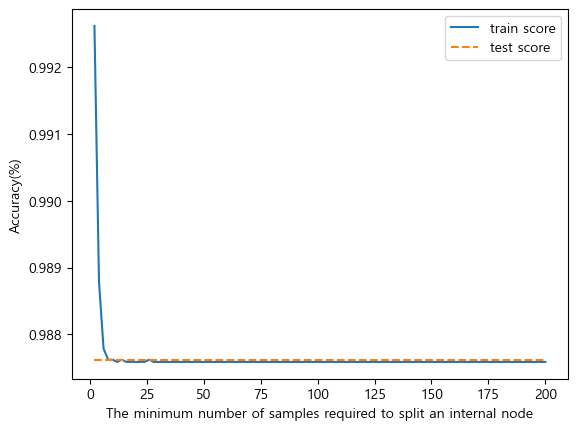

In [61]:
### 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 분리 노드의 최소 자료 수 선정
### 분리 노드의 최소 자료 수가 클수록 분류 기준이 엄격해져 과대적합 방지가 용이함

n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit(algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

In [62]:
### 해석
# 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 분리 노드의 최소 자료 수 선정
# 분리 노드의 최소 자료 수가 클수록 분류 기준이 엄격해져 과대적합 방지가 용이함
# 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전인 최적의 분리 노드의 최소 자료 수 선정

### 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전인 최적의 분리 노드의 최소 자료 수 선정
n_split = 8

### 3-1-4. 모델 최적화 : (4) 잎사귀 노드의 최소 자료 수 선정

    min_samples_leaf  TrainScore  TestScore    Minus
0                  2     0.98759    0.98762 -0.00003
1                  4     0.98759    0.98762 -0.00003
2                  6     0.98759    0.98762 -0.00003
3                  8     0.98759    0.98762 -0.00003
4                 10     0.98759    0.98762 -0.00003
5                 12     0.98759    0.98762 -0.00003
6                 14     0.98759    0.98762 -0.00003
7                 16     0.98759    0.98762 -0.00003
8                 18     0.98759    0.98762 -0.00003
9                 20     0.98759    0.98762 -0.00003
10                22     0.98759    0.98762 -0.00003
11                24     0.98759    0.98762 -0.00003
12                26     0.98759    0.98762 -0.00003
13                28     0.98759    0.98762 -0.00003
14                30     0.98759    0.98762 -0.00003
15                32     0.98759    0.98762 -0.00003
16                34     0.98759    0.98762 -0.00003
17                36     0.98759    0.98762 -0

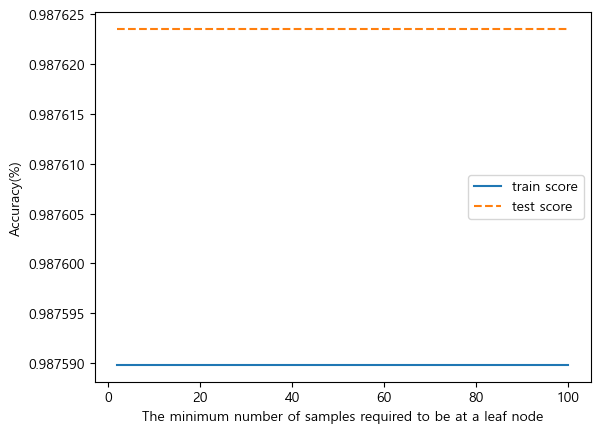

In [63]:
### 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 잎사귀 노드의 최소 자료 수 선정
### 잎사귀 노드의 최소 자료 수가 클수록 분류 기준이 엄격해져 과대적합 방지가 용이함

n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               x_train, y_train, x_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

In [64]:
### 해석
# 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 잎사귀 노드의 최소 자료 수 선정
# 잎사귀 노드의 최소 자료 수가 클수록 분류 기준이 엄격해져 과대적합 방지가 용이함
# 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전인 최적의 잎사귀 노드의 최소 자료 수 선정

n_leaf = 10

## 3-2. 랜덤포레스트 : 최종 모델 평가

Model =>  RandomForestClassifier(max_depth=19, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=40, random_state=1234)
최종 모델 저장 완료! 파일 경로: ./model2/classification_RandomForestClassifier.pkl

train_acc: 0.988
test_acc: 0.988
Accuracy: 0.988
Precision: 0.000
Recall: 0.000
F1-score: 0.000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x3000 with 0 Axes>

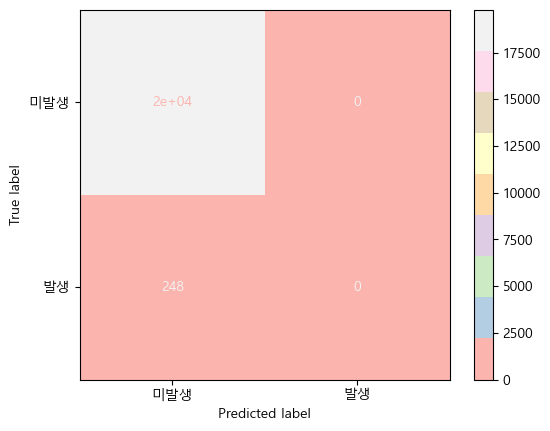

   Feature  Importance
1  Voltage     0.40981
2       pH     0.38656
0     Temp     0.20364


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model_Name(모델명),train_acc(훈련 정확도),test_acc(예측 정확도),test-train(예측-훈련),Precision(정밀도),Recall(재현율),F1-score(F1스코어)
0,RandomForestClassifier,0.9876,0.9876,0.0,0.0,0.0,0.0


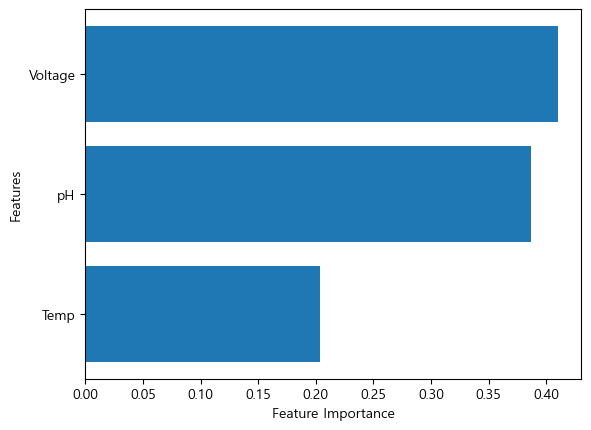

In [65]:
df_models_res = model_final(algorithm, algorithm_name, feature_name,
                        x_train, y_train, x_test, y_test,
                        n_estimator, n_depth, n_split, n_leaf)
df_models_res

# 4. 최종 훈련모델들 검증(전체 분류 알고리즘 한번에 처리) : 최종 모델 학습

< RandomForestClassifier - 알고리즘>
Model =>  RandomForestClassifier(max_depth=19, min_samples_leaf=10, min_samples_split=8,
                       n_estimators=40, random_state=1234)
최종 모델 저장 완료! 파일 경로: ./model2/classification_RandomForestClassifier.pkl

train_acc: 0.988
test_acc: 0.988
Accuracy: 0.988
Precision: 0.000
Recall: 0.000
F1-score: 0.000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x3000 with 0 Axes>

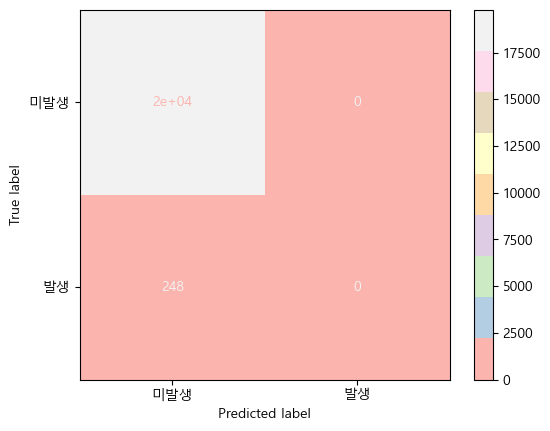

   Feature  Importance
1  Voltage     0.40981
2       pH     0.38656
0     Temp     0.20364


< ExtraTreesClassifier - 알고리즘>
Model =>  ExtraTreesClassifier(max_depth=19, min_samples_leaf=10, min_samples_split=8,
                     random_state=1234)


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


최종 모델 저장 완료! 파일 경로: ./model2/classification_ExtraTreesClassifier.pkl

train_acc: 0.988
test_acc: 0.988
Accuracy: 0.988
Precision: 0.000
Recall: 0.000
F1-score: 0.000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


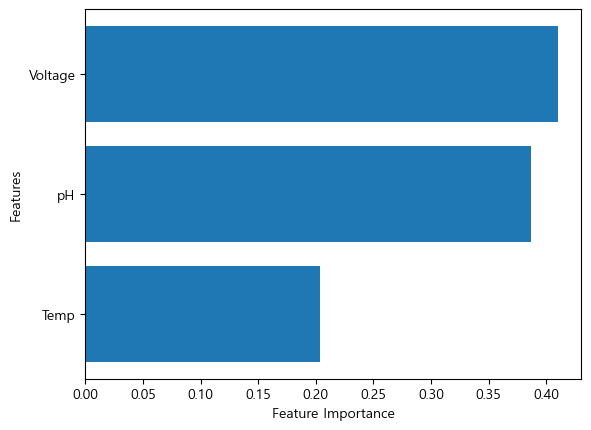

<Figure size 3000x3000 with 0 Axes>

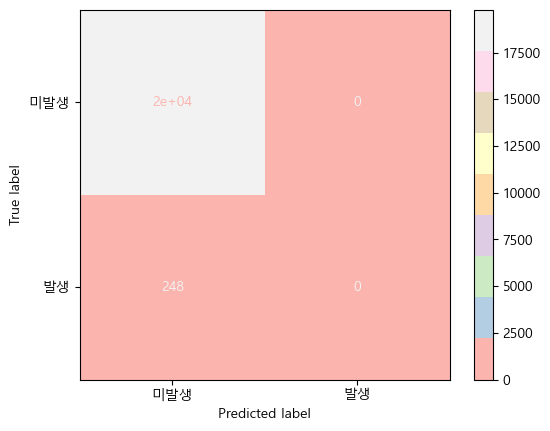

   Feature  Importance
1  Voltage     0.35313
0     Temp     0.32757
2       pH     0.31930


< GradientBoostingClassifier - 알고리즘>
Model =>  GradientBoostingClassifier(max_depth=19, min_samples_leaf=10,
                           min_samples_split=8, random_state=1234)


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


최종 모델 저장 완료! 파일 경로: ./model2/classification_GradientBoostingClassifier.pkl

train_acc: 1.000
test_acc: 0.987
Accuracy: 0.987
Precision: 0.125
Recall: 0.008
F1-score: 0.015


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


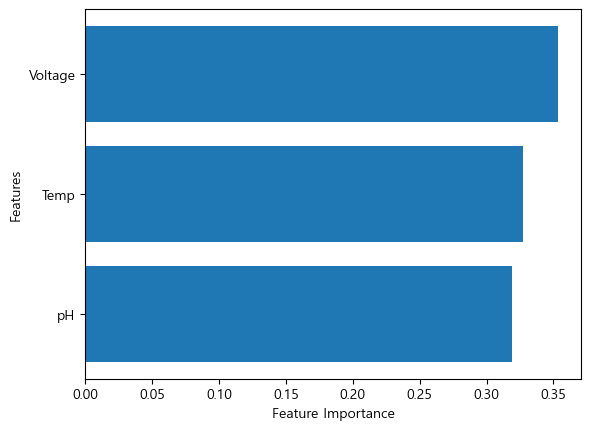

<Figure size 3000x3000 with 0 Axes>

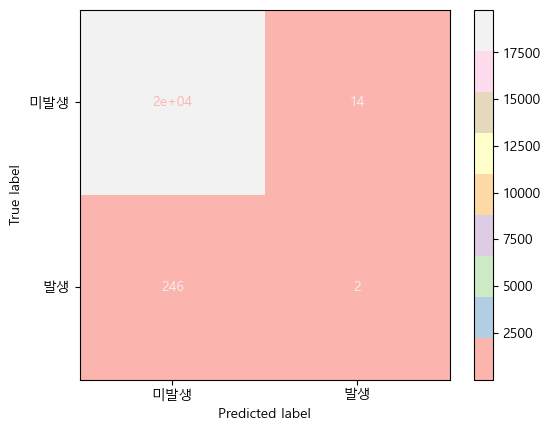

   Feature  Importance
1  Voltage     0.39915
2       pH     0.36192
0     Temp     0.23893


< HistGradientBoostingClassifier - 알고리즘>
Model =>  HistGradientBoostingClassifier(max_depth=19, min_samples_leaf=10,
                               random_state=1234)
최종 모델 저장 완료! 파일 경로: ./model2/classification_HistGradientBoostingClassifier.pkl

train_acc: 0.988
test_acc: 0.988
Accuracy: 0.988
Precision: 0.000
Recall: 0.000
F1-score: 0.000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


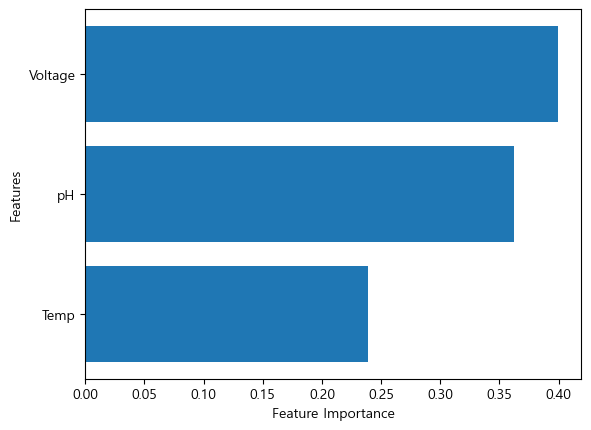

<Figure size 3000x3000 with 0 Axes>

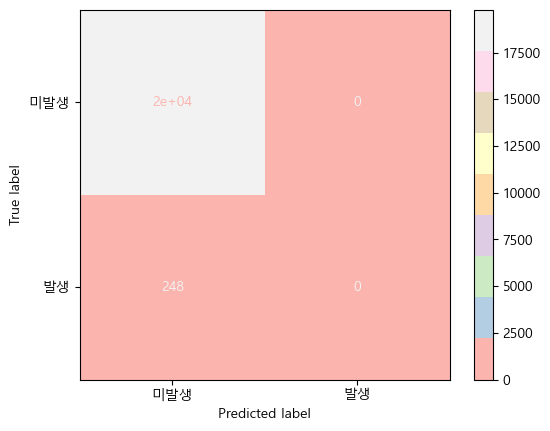

   Feature  Importance
0     Temp     0.00006
2       pH     0.00005
1  Voltage     0.00004


< XGBClassifier - 알고리즘>
Model =>  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=19,
              min_child_weight=None, min_samples_leaf=10, min_samples_split=8,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=1234, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[01:18:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: {

C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


최종 모델 저장 완료! 파일 경로: ./model2/classification_XGBClassifier.pkl

train_acc: 0.999
test_acc: 0.987
Accuracy: 0.987
Precision: 0.000
Recall: 0.000
F1-score: 0.000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


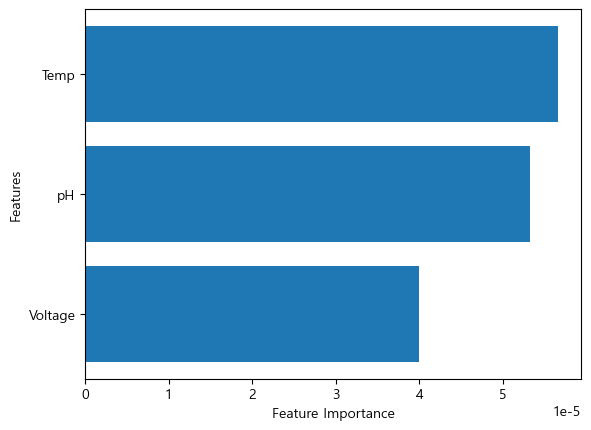

<Figure size 3000x3000 with 0 Axes>

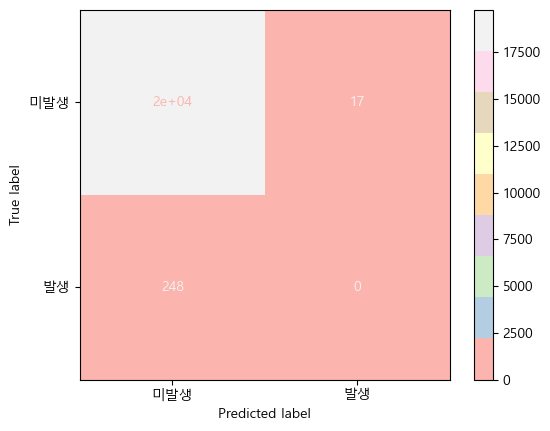

   Feature  Importance
1  Voltage     0.01208
2       pH     0.01194
0     Temp     0.01159


< LGBMClassifier - 알고리즘>
Model =>  LGBMClassifier(max_depth=19, min_samples_leaf=10, min_samples_split=8,
               random_state=1234)
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
최종 모델 저장 완료! 파일 경로: ./model2/classification_LGBMClassifier.pkl

train_acc: 0.988
test_acc: 0.988
Accuracy: 0.988
Precision: 0.000
Recall: 0.000
F1-score: 0.000


C:\Users\mento\anaconda3\envs\lecture_ml\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


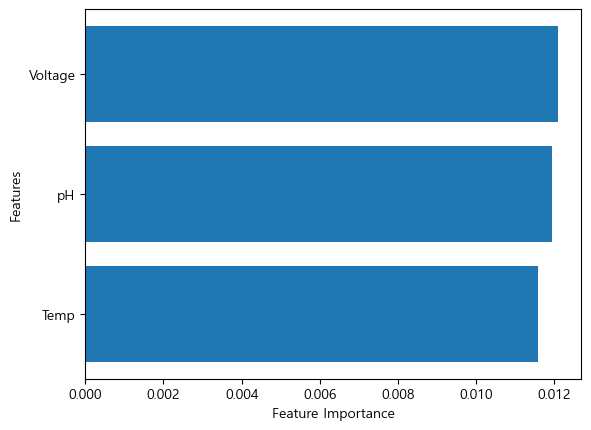

<Figure size 3000x3000 with 0 Axes>

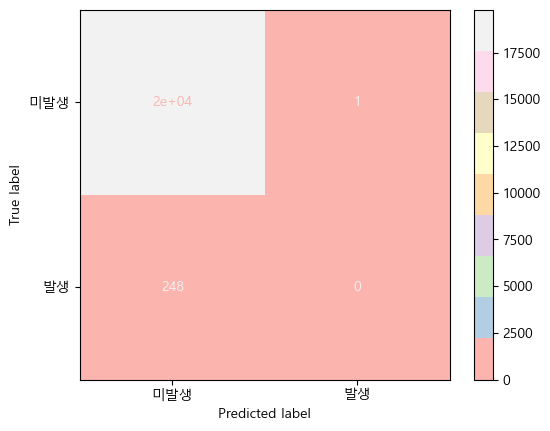

   Feature  Importance
0     Temp     0.00083
2       pH     0.00081
1  Voltage     0.00080




,Model_Name(모델명),train_acc(훈련 정확도),test_acc(예측 정확도),test-train(예측-훈련),Precision(정밀도),Recall(재현율),F1-score(F1스코어)
0,RandomForestClassifier,0.9876,0.9876,0.0000,0.000,0.0000,0.0000
1,ExtraTreesClassifier,0.9876,0.9876,0.0000,0.000,0.0000,0.0000
2,GradientBoostingClassifier,0.9999,0.9870,-0.0129,0.125,0.0081,0.0152
3,HistGradientBoostingClassifier,0.9876,0.9876,0.0000,0.000,0.0000,0.0000
4,XGBClassifier,0.9992,0.9868,-0.0124,0.000,0.0000,0.0000
5,LGBMClassifier,0.9884,0.9876,-0.0008,0.000,0.0000,0.0000


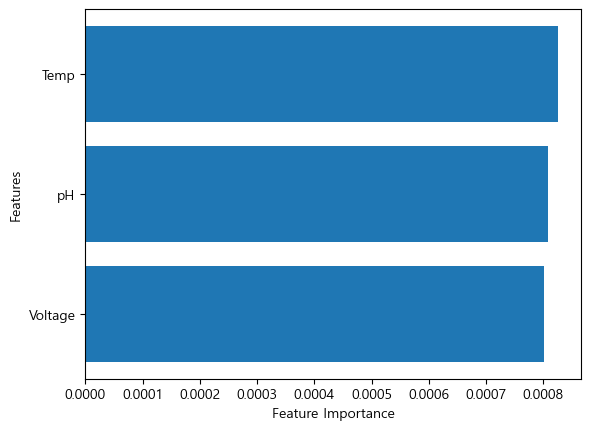

In [66]:
algorithm_list = [RandomForestClassifier,
                  ExtraTreesClassifier, 
                  GradientBoostingClassifier, 
                  HistGradientBoostingClassifier, 
                  XGBClassifier, 
                  LGBMClassifier]

algorithm_name_list = ['RandomForestClassifier',
                       'ExtraTreesClassifier', 
                       'GradientBoostingClassifier',
                       'HistGradientBoostingClassifier', 
                       'XGBClassifier', 
                       'LGBMClassifier']


### 모델별 검증결과 데이터프레임에 저장하기 (모델별 검증 데이터 비교 확인용)
df_models_finally = pd.DataFrame(columns=["Model_Name(모델명)", "train_acc(훈련 정확도)", "test_acc(예측 정확도)",  
                                          "test-train(예측-훈련)", "Precision(정밀도)", "Recall(재현율)", "F1-score(F1스코어)"])

### 모델별 검증 실행하기
for i in range(0, len(algorithm_list), 1) :
    print("< {} - 알고리즘>".format(algorithm_name_list[i]))
    
    df_models_res = model_final(algorithm_list[i], algorithm_name_list[i], feature_name,
                                x_train, y_train, x_test, y_test,
                                n_estimator, n_depth, n_split, n_leaf)
    
    df_models_finally = pd.concat([df_models_finally, df_models_res], ignore_index=True)
    
    print("\n============================================\n")
    
df_models_finally